In [1]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.backend import clear_session
import tensorflow as tf

warnings.simplefilter('ignore')
plt.style.use('fivethirtyeight')

In [40]:
data_dir = Path('data')

df = pd.read_csv(
    data_dir / 'SPP_MSFT.csv',
    usecols=['DNCP','OPCP','HPCP','LPCP','CPCP','ACPCP','VTCP','MPN5P']
)

df['DATE'] = pd.to_datetime(df['DNCP'], origin='1899-12-30', unit='D')
df = df.drop('DNCP',axis=1)
df = df.set_index('DATE')

df.head()

,OPCP,HPCP,LPCP,CPCP,ACPCP,VTCP,MPN5P
DATE,,,,,,,
2000-02-29,45.87500,45.875000,44.43750,44.68750,27.880445,58437400,46.765625
2000-03-01,44.81250,47.046875,44.46875,45.40625,28.328880,106889800,47.070312
2000-03-02,45.90625,47.687500,45.56250,46.68750,29.128248,106932600,47.656250
2000-03-03,47.37500,49.437500,46.93750,48.06250,29.986110,101435200,48.000000
2000-03-06,48.00000,48.687500,45.06250,45.31250,28.270390,93609400,48.750000


#### Prepare the dataset

In [41]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    #input sequence
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #forecast sequence
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols,axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [42]:
#scale
data = df.values
data = data.astype('float32')

scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data)

dataset = series_to_supervised(data=data,n_in=60,n_out=1)

dataset.head()

,var1(t-60),var2(t-60),var3(t-60),var4(t-60),var5(t-60),var6(t-60),var7(t-60),var1(t-59),var2(t-59),var3(t-59),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
60,0.091262,0.090085,0.090329,0.088715,0.049014,0.087405,0.095920,0.088101,0.093574,0.090425,...,0.024753,0.086592,0.048957,0.048681,0.052587,0.050805,0.052955,0.026953,0.133744,0.048957
61,0.088101,0.093574,0.090425,0.090873,0.050345,0.170424,0.096857,0.091355,0.095482,0.093766,...,0.026953,0.133744,0.048957,0.050819,0.049888,0.047941,0.046854,0.023190,0.148936,0.049966
62,0.091355,0.095482,0.093766,0.094721,0.052719,0.170498,0.098659,0.095725,0.100692,0.097967,...,0.023190,0.148936,0.049966,0.047100,0.046725,0.046795,0.046760,0.023132,0.082924,0.051384
63,0.095725,0.100692,0.097967,0.098851,0.055267,0.161078,0.099716,0.097584,0.098459,0.092239,...,0.023132,0.082924,0.051384,0.047658,0.048958,0.049277,0.049670,0.024927,0.104709,0.053594
64,0.097584,0.098459,0.092239,0.090592,0.050172,0.147669,0.102022,0.097770,0.098645,0.095007,...,0.024927,0.104709,0.053594,0.049448,0.048330,0.049373,0.048449,0.024174,0.081461,0.054849


In [43]:
dataset = dataset.values

# train test split
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

train,test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
X_train,y_train = train[:,:-1], train[:,-1]
X_test, y_test = test[:,:-1], test[:,-1]

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3897, 1, 426) (3897,) (1920, 1, 426) (1920,)


#### Build the Model

In [6]:
from keras.metrics import RootMeanSquaredError

clear_session()

model = Sequential([
    LSTM(50,return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    LSTM(50,return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(
    optimizer='Adam',
    loss='mean_squared_error',
    metrics=[RootMeanSquaredError()]
)

In [7]:
history = model.fit(X_train,
                    y_train,
                    batch_size=1,
                    validation_data=(X_test,y_test),
                    verbose=2,
                    epochs=20)

model.save('models/raw_features_lstmv1.h5')

Epoch 1/20
3897/3897 - 26s - loss: 4.7103e-05 - root_mean_squared_error: 0.0069 - val_loss: 0.1475 - val_root_mean_squared_error: 0.3840 - 26s/epoch - 7ms/step
Epoch 2/20
3897/3897 - 17s - loss: 2.1412e-05 - root_mean_squared_error: 0.0046 - val_loss: 0.1537 - val_root_mean_squared_error: 0.3921 - 17s/epoch - 4ms/step
Epoch 3/20
3897/3897 - 17s - loss: 1.7789e-05 - root_mean_squared_error: 0.0042 - val_loss: 0.1605 - val_root_mean_squared_error: 0.4006 - 17s/epoch - 4ms/step
Epoch 4/20
3897/3897 - 17s - loss: 1.4719e-05 - root_mean_squared_error: 0.0038 - val_loss: 0.1577 - val_root_mean_squared_error: 0.3971 - 17s/epoch - 4ms/step
Epoch 5/20
3897/3897 - 17s - loss: 1.3106e-05 - root_mean_squared_error: 0.0036 - val_loss: 0.1595 - val_root_mean_squared_error: 0.3994 - 17s/epoch - 4ms/step
Epoch 6/20
3897/3897 - 17s - loss: 1.3003e-05 - root_mean_squared_error: 0.0036 - val_loss: 0.1686 - val_root_mean_squared_error: 0.4106 - 17s/epoch - 4ms/step
Epoch 7/20
3897/3897 - 17s - loss: 1.164

#### Model Evaluation

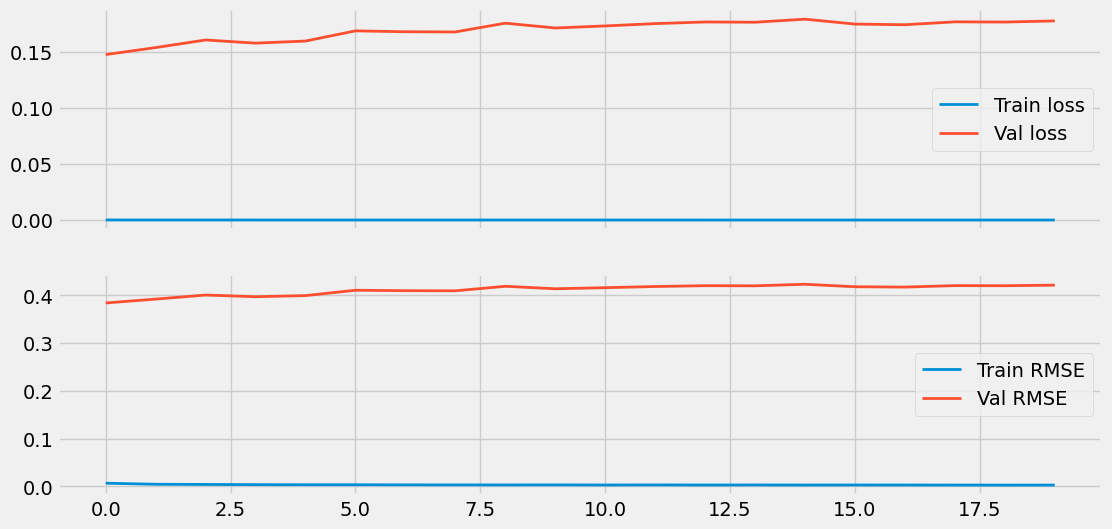

In [16]:
history_df = pd.DataFrame(history.history)

plt.rc(
    'lines',
    linewidth=2
)

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6),sharex=True)

history_df['loss'].plot(ax=ax1, label='Train loss')
history_df['val_loss'].plot(ax=ax1, label='Val loss')
ax1.legend()

history_df['root_mean_squared_error'].plot(ax=ax2, label='Train RMSE')
history_df['val_root_mean_squared_error'].plot(ax=ax2, label='Val RMSE')
ax2.legend()

plt.show()

#### Post Processing and Prediction

In [44]:
from keras.models import load_model
model = load_model('models/raw_features_lstmv1.h5')

preds = model.predict(X_test)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[2])
inv_preds = np.concatenate((preds,X_test[:,1:]),axis=1)
inv_preds = scaler.inverse_transform(inv_preds)

inv_preds

60/60 [==============================] - 1s 2ms/step


ValueError: ignored

In [38]:
inv_preds.shape

(1920, 426)

In [36]:
X_test

array([[[0.07976317, 0.08104809, 0.080011  , ..., 0.11650397,
         0.10947396, 0.03550832]],

       [[0.08339284, 0.08435313, 0.08572388, ..., 0.11725484,
         0.11013795, 0.05092639]],

       [[0.08389862, 0.08494864, 0.08712919, ..., 0.11725484,
         0.11013795, 0.03565687]],

       ...,

       [[0.8152089 , 0.8157809 , 0.8243973 , ..., 0.97948635,
         0.9797163 , 0.03552888]],

       [[0.80492085, 0.8046747 , 0.8149879 , ..., 0.96732235,
         0.9676887 , 0.0235762 ]],

       [[0.8020648 , 0.8080691 , 0.8159655 , ..., 0.9511337 ,
         0.9516814 , 0.04335374]]], dtype=float32)